# Evaluación e Inferencia de Modelos

Este notebook contiene las funciones y código necesario para evaluar los modelos entrenados (ResNet50, MobileNet V3 Large, EfficientNet B3) y realizar inferencias sobre el conjunto de datos de prueba.

## Contenido:
1. **Configuración inicial** - Importación de librerías y configuración del dispositivo
2. **Funciones de utilidad** - Transformaciones, cargadores de datos y construcción de modelos
3. **Evaluación** - Métricas completas y visualización de resultados
4. **Inferencia** - Predicciones sobre imágenes individuales
5. **Resultados por modelo** - Análisis detallado de cada arquitectura

## 1. Configuración Inicial

### Importación de Librerías
Importamos todas las librerías necesarias para la evaluación, incluyendo PyTorch, sklearn para métricas, y utilidades para visualización.

In [ ]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List

from torchvision import models, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    roc_auc_score, average_precision_score, classification_report,
    cohen_kappa_score, matthews_corrcoef
)
from sklearn.preprocessing import label_binarize

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

from PIL import Image
from IPython.display import HTML
from io import BytesIO
import random
import base64

## 2. Configuración de Datos y Transformaciones

### Rutas y Configuración
Definimos las rutas base para los datos y el prefijo utilizado para guardar los checkpoints. También configuramos las transformaciones específicas para cada arquitectura.

In [ ]:
DATA_BASE = "/content/drive/MyDrive/data/versionB"
OUT_PREFIX = "run_vB" # prefijo usado al guardar checkpoints/historias

WEIGHTS_MAP = {
    "resnet50":            models.ResNet50_Weights.DEFAULT,
    "efficientnet_b3":     models.EfficientNet_B3_Weights.DEFAULT,
    "mobilenet_v3_large":  models.MobileNet_V3_Large_Weights.DEFAULT,
}

def get_transforms(arch: str):
    return WEIGHTS_MAP[arch.lower()].transforms(antialias=True)

def get_data_loader(base_dir: str, arch: str, partition: str = "test", batch_size: int = 32, num_workers: int = 8):
    tfm = get_transforms(arch)
    ds  = datasets.ImageFolder(os.path.join(base_dir, partition), transform=tfm)
    loader = DataLoader(
        ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True, persistent_workers=True
    )
    return loader

## 3. Construcción y Carga de Modelos

### Función para Construir Modelos
Esta función construye los modelos para evaluación, configurando las capas finales según la arquitectura específica.

In [ ]:
def build_model_for_eval(arch: str, num_classes: int, dropout: float = 0.2, compile_model: bool = True):
    arch = arch.lower()

    if arch == "resnet50":
        m = models.resnet50(weights=None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, num_classes))

    elif arch == "efficientnet_b3":
        m = models.efficientnet_b3(weights=None)
        in_f = m.classifier[1].in_features
        m.classifier[1] = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, num_classes))

    elif arch == "mobilenet_v3_large":
        m = models.mobilenet_v3_large(weights=None)
        in_f = m.classifier[3].in_features
        m.classifier[3] = nn.Sequential(nn.Dropout(dropout), nn.Linear(in_f, num_classes))

    m = m.to(DEVICE).to(memory_format=torch.channels_last)
    if compile_model:
        try:
            m = torch.compile(m, mode="reduce-overhead", fullgraph=False)
        except Exception:
            pass
    return m

### Carga de Checkpoints
Función para cargar modelos pre-entrenados desde archivos de checkpoint, incluyendo la arquitectura, número de clases y mapeo de clases.

In [200]:
def load_checkpoint(ckpt_path: str):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    arch = ckpt["arch"]; num_classes = ckpt["num_classes"]
    class_to_idx = ckpt.get("class_to_idx", None)
    model = build_model_for_eval(arch, num_classes, dropout=0.2, compile_model=True)
    model.load_state_dict(ckpt["state_dict"], strict=True)
    model.eval()
    return model, arch, num_classes, class_to_idx

## 4. Funciones de Evaluación

### Evaluación Completa
Esta función realiza una evaluación exhaustiva del modelo, calculando múltiples métricas incluyendo:
- **Accuracy y Balanced Accuracy**
- **F1-Score, Precision y Recall (macro)**
- **AUC y Average Precision**
- **Cohen's Kappa y Matthews Correlation Coefficient**
- **Matriz de confusión y reporte de clasificación**

In [ ]:
@torch.no_grad()
def evaluate_full(model: nn.Module, loader) -> Dict:
    criterion = nn.CrossEntropyLoss()
    losses, y_true, y_prob = [], [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        y_true.extend(y.detach().cpu().tolist())
        y_prob.extend(torch.softmax(logits, dim=1).detach().cpu().tolist())

    y_true = np.array(y_true); y_prob = np.array(y_prob)
    y_pred = y_prob.argmax(axis=1)
    C = y_prob.shape[1]

    acc     = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1m     = f1_score(y_true, y_pred, average="macro")
    prem    = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recm    = recall_score(y_true, y_pred, average="macro")

    try:
        auc_macro = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
    except ValueError:
        auc_macro = float("nan")
    try:
        y_bin = label_binarize(y_true, classes=np.arange(C))
        ap_macro = average_precision_score(y_bin, y_prob, average="macro")
    except ValueError:
        ap_macro = float("nan")

    kappa = cohen_kappa_score(y_true, y_pred)
    mcc   = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    return {
        "loss": float(np.mean(losses)),
        "acc": float(acc),
        "bal_acc": float(bal_acc),
        "f1_macro": float(f1m),
        "precision_macro": float(prem),
        "recall_macro": float(recm),
        "auc_macro": float(auc_macro),
        "ap_macro": float(ap_macro),
        "kappa": float(kappa),
        "mcc": float(mcc),
    }, cm, cr

## 5. Funciones de Visualización

### Historial de Entrenamiento y Matrices de Confusión
Funciones para visualizar el progreso del entrenamiento y los resultados de clasificación:

In [ ]:
def load_history(hist_path: str) -> List[Dict]:
    blob = torch.load(hist_path, map_location="cpu", weights_only=False)
    return blob["history"]

def plot_series(values: List[float], title: str, ylabel: str):
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(values)+1), values, marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def plot_confusion(cm: np.ndarray, class_names: List[str], title: str):
    plt.figure(figsize=(5,5))
    im = plt.imshow(cm, interpolation='nearest', cmap="Oranges")
    plt.title(title)
    plt.colorbar(im)
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, ha='right')
    plt.yticks(ticks, class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.tight_layout(); plt.show()

## 6. Funciones de Inferencia

### Predicción en Imágenes Individuales
Funciones para realizar inferencias en imágenes de prueba y mostrar los resultados con visualización:

In [ ]:
def preprocess_single(arch: str):
    return get_transforms(arch)

def img_to_html(path: str, size: int = 144) -> str:
    img = Image.open(path).convert("RGB")
    img.thumbnail((size, size))
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    data = base64.b64encode(buffer.getvalue()).decode()
    return f'<img src="data:image/png;base64,{data}">'

def get_test_image_paths(base_dir: str, n: int = 6, seed: int = 42):
    paths = []
    paths.extend(glob.glob(os.path.join(base_dir, "test", "*", "*.jpg")))
    random.Random(seed).shuffle(paths)
    return paths[:n]

@torch.no_grad()
def infer_images(ckpt_path, path: str = "/content/drive/MyDrive/data/versionB", topk: int = 3) -> pd.DataFrame:
    model, arch_loaded, num_classes, class_to_idx = load_checkpoint(ckpt_path)
    tfm = preprocess_single(arch_loaded)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    rows = []
    image_paths = get_test_image_paths(path)

    for p in image_paths:
        true_label = os.path.basename(os.path.dirname(p))
        true_idx = class_to_idx.get(true_label) if class_to_idx else None

        img = Image.open(p).convert("RGB")
        x = tfm(img).unsqueeze(0).to(DEVICE)
        probs = torch.softmax(model(x), dim=1).squeeze(0).cpu().numpy()
        top_idx = probs.argsort()[::-1][:topk]
        top_lbl = [idx_to_class[i] if idx_to_class else str(i) for i in top_idx]
        top_pr  = [float(probs[i]) for i in top_idx]

        rows.append({
            "preview": img_to_html(p),
            "image": os.path.basename(p),
            "true_label": true_idx,
            **{f"top{i+1}_label": top_lbl[i] for i in range(len(top_lbl))},
            **{f"top{i+1}_prob":  top_pr[i]  for i in range(len(top_pr))}
        })
    df = pd.DataFrame(rows)
    return HTML(df.to_html(escape=False))

## 7. Función Principal de Evaluación

### Evaluación por Arquitectura
Función principal que combina todas las funcionalidades anteriores para evaluar un modelo específico:

In [ ]:
def run_eval_for_arch(
    arch: str,
    out_prefix: str = OUT_PREFIX,
    data_base: str = DATA_BASE,
    batch_size: int = 32,
    num_workers: int = 8,
    partition: str = "test",
):
    ckpt_path = f"./{out_prefix}_{arch}_best.pth"

    model, _, _, _ = load_checkpoint(ckpt_path)
    loader = get_data_loader(data_base, arch, partition, batch_size=batch_size, num_workers=num_workers)
    m, cm, cr = evaluate_full(model, loader)
    print(
        f"[{arch}] "
        f"acc={m['acc']:.4f} balAcc={m['bal_acc']:.4f} "
        f"f1M={m['f1_macro']:.4f} AUC={m['auc_macro']:.4f} AP={m['ap_macro']:.4f} "
        f"kappa={m['kappa']:.4f} mcc={m['mcc']:.4f}"
    )
    print("\n============== Classification Report ===============")
    print(cr)

    plot_confusion(cm, loader.dataset.classes, title=f"Confusion Matrix - {partition} - {arch}")
    metrics_df = pd.DataFrame([m], index=[arch])

    return m, metrics_df

---

# 🔍 EVALUACIÓN DE MODELOS

## Evaluación en Conjunto de Validación

En esta sección evaluamos el rendimiento de los tres modelos entrenados (ResNet50, MobileNet V3 Large, y EfficientNet B3) en el conjunto de datos de validación para comparar su desempeño antes de la evaluación final en test.

### 🏗️ ResNet50 - Validación

Evaluación del modelo ResNet50 en el conjunto de validación:

[resnet50] acc=0.8786 balAcc=0.8160 f1M=0.8212 AUC=0.9542 AP=0.8645 kappa=0.7964 mcc=0.7966

============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       361
           1       0.83      0.84      0.84       274
           2       0.69      0.63      0.66        98

    accuracy                           0.88       733
   macro avg       0.83      0.82      0.82       733
weighted avg       0.88      0.88      0.88       733



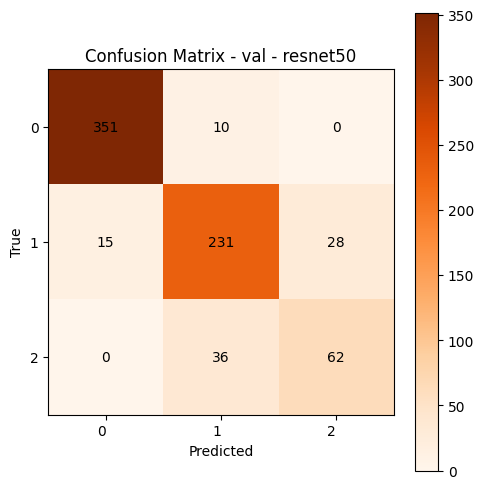

In [213]:
m_resnet_val, resnet_metrics_df_val = run_eval_for_arch("resnet50", partition="val")

In [214]:
resnet_metrics_df_val

,loss,acc,bal_acc,f1_macro,precision_macro,recall_macro,auc_macro,ap_macro,kappa,mcc
resnet50,0.334874,0.878581,0.816006,0.821221,0.82728,0.816006,0.954193,0.864515,0.796417,0.796553


### 📱 MobileNet V3 Large - Validación

Evaluación del modelo MobileNet V3 Large en el conjunto de validación:

[mobilenet_v3_large] acc=0.9004 balAcc=0.8521 f1M=0.8509 AUC=0.9491 AP=0.8580 kappa=0.8341 mcc=0.8341

============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       361
           1       0.87      0.86      0.87       274
           2       0.70      0.71      0.71        98

    accuracy                           0.90       733
   macro avg       0.85      0.85      0.85       733
weighted avg       0.90      0.90      0.90       733



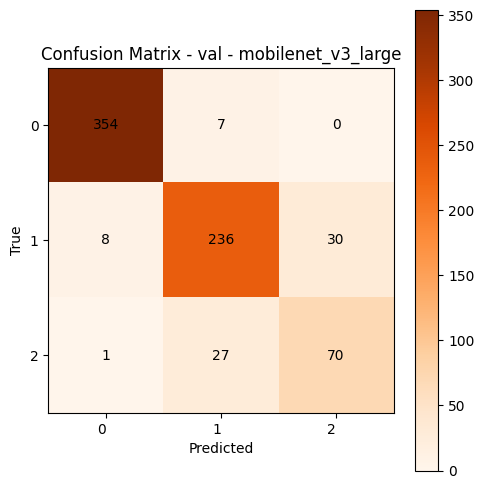

In [216]:
m_mobilenet_val, mobilenet_metrics_df_val = run_eval_for_arch("mobilenet_v3_large", partition="val")

In [217]:
mobilenet_metrics_df_val

,loss,acc,bal_acc,f1_macro,precision_macro,recall_macro,auc_macro,ap_macro,kappa,mcc
mobilenet_v3_large,0.328133,0.900409,0.85207,0.850873,0.84976,0.85207,0.949066,0.858025,0.834063,0.834094


### ⚡ EfficientNet B3 - Validación

Evaluación del modelo EfficientNet B3 en el conjunto de validación:

[efficientnet_b3] acc=0.9018 balAcc=0.8432 f1M=0.8487 AUC=0.9405 AP=0.8489 kappa=0.8357 mcc=0.8361

============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       361
           1       0.85      0.89      0.87       274
           2       0.73      0.66      0.70        98

    accuracy                           0.90       733
   macro avg       0.86      0.84      0.85       733
weighted avg       0.90      0.90      0.90       733



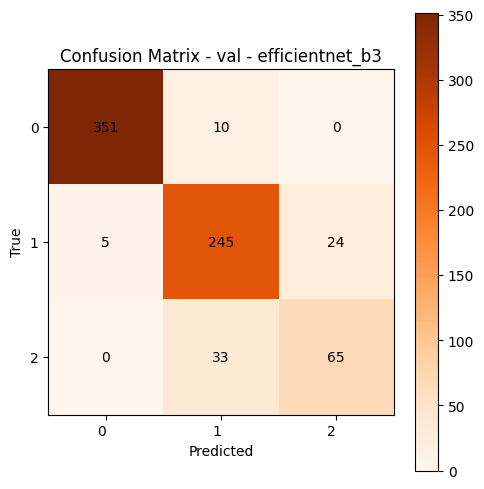

In [218]:
m_efficientnet_val, efficientnet_metrics_df_val = run_eval_for_arch("efficientnet_b3", partition="val")

In [219]:
efficientnet_metrics_df_val

,loss,acc,bal_acc,f1_macro,precision_macro,recall_macro,auc_macro,ap_macro,kappa,mcc
efficientnet_b3,0.342358,0.901774,0.843242,0.848718,0.855662,0.843242,0.940542,0.848913,0.83566,0.83606


---

## Evaluación en Conjunto de Test

En esta sección realizamos la evaluación final de los modelos en el conjunto de test. Incluimos:
- **Visualización del historial de entrenamiento** (loss, métricas por época)
- **Métricas finales** en el conjunto de test
- **Matrices de confusión** para análisis detallado
- **Inferencias en imágenes individuales** para validar predicciones

### 🏗️ ResNet50 - Evaluación Completa

#### Historial de Entrenamiento
Visualizamos el progreso del entrenamiento a través de las épocas:

In [222]:
resnet_history = load_history("./run_vB_resnet50_history.pt")

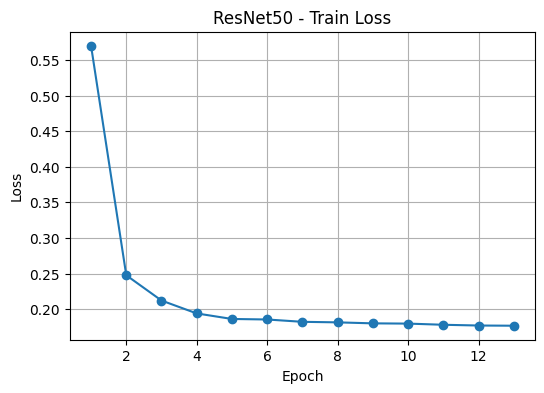

In [223]:
train_loss = [h["train_loss"] for h in resnet_history]
plot_series(train_loss, title="ResNet50 - Train Loss", ylabel="Loss")

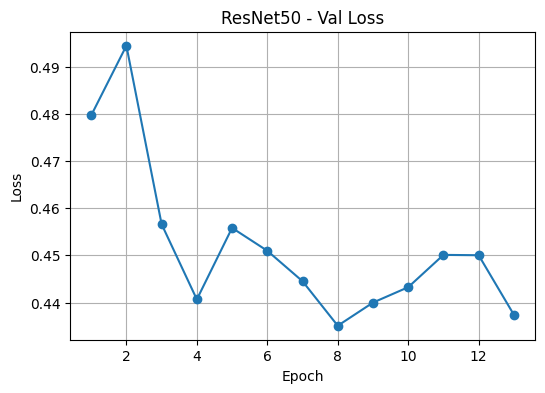

In [224]:
val_loss = [h["loss"] for h in resnet_history]
plot_series(val_loss, title="ResNet50 - Val Loss", ylabel="Loss")

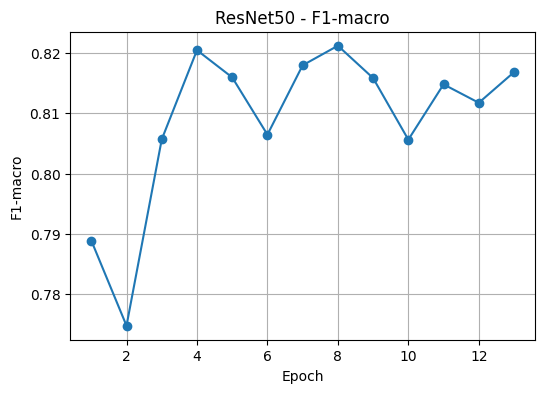

In [226]:
f1_macro = [h["f1_macro"] for h in resnet_history]
plot_series(f1_macro, title="ResNet50 - F1-macro", ylabel="F1-macro")

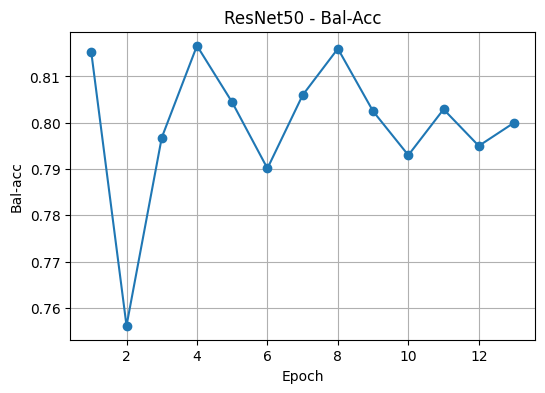

In [230]:
bal_acc = [h["bal_acc"] for h in resnet_history]
plot_series(bal_acc, title="ResNet50 - Bal-Acc", ylabel="Bal-acc")

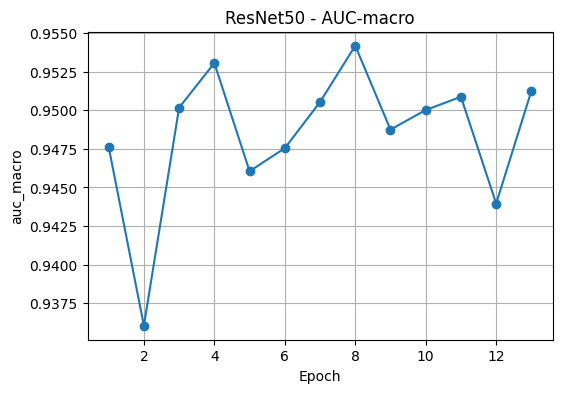

In [228]:
auc_macro = [h["auc_macro"] for h in resnet_history]
plot_series(auc_macro, title="ResNet50 - AUC-macro", ylabel="auc_macro")

#### Métricas en Test y Matriz de Confusión

[resnet50] acc=0.8880 balAcc=0.8349 f1M=0.8377 AUC=0.9532 AP=0.8659 kappa=0.8126 mcc=0.8126

============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       361
           1       0.85      0.86      0.85       274
           2       0.71      0.68      0.69        97

    accuracy                           0.89       732
   macro avg       0.84      0.83      0.84       732
weighted avg       0.89      0.89      0.89       732



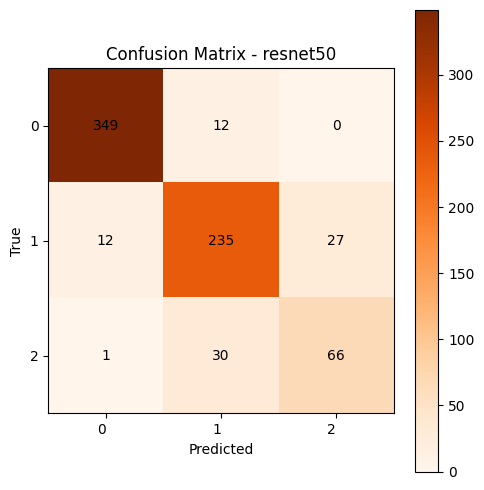

In [167]:
m_resnet, resnet_metrics_df = run_eval_for_arch("resnet50")

In [168]:
resnet_metrics_df

,loss,acc,bal_acc,f1_macro,precision_macro,recall_macro,auc_macro,ap_macro,kappa,mcc
resnet50,0.33022,0.887978,0.834945,0.837718,0.840714,0.834945,0.953169,0.865906,0.812556,0.812591


#### Ejemplos de Inferencia

Predicciones en imágenes de prueba seleccionadas aleatoriamente:

,preview,image,true_label,top1_label,top2_label,top3_label,top1_prob,top2_prob,top3_prob
0,,d0ffa0425ef1.jpg,2,2,1,0,0.896639,0.092795,0.010566
1,,8a81f62320d6.jpg,0,0,2,1,0.969255,0.016284,0.014461
2,,cb2f3c5d71a7.jpg,1,0,1,2,0.526257,0.383007,0.090736
3,,a19507501b40.jpg,1,1,0,2,0.946468,0.028017,0.025516
4,,2b21d293fdf2.jpg,1,1,2,0,0.951498,0.027699,0.020803
5,,52ae917fcea4.jpg,1,1,0,2,0.927907,0.046592,0.025501

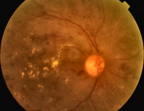
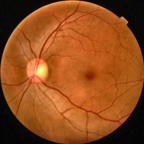
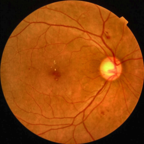
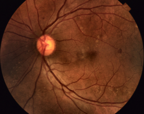
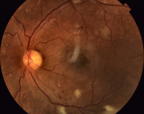
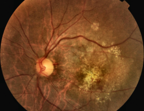

In [189]:
infer_images("run_vB_resnet50_best.pth")

---

### 📱 MobileNet V3 Large - Evaluación Completa

#### Historial de Entrenamiento

In [251]:
mobilenet_history = load_history("./run_vB_mobilenet_v3_large_history.pt")

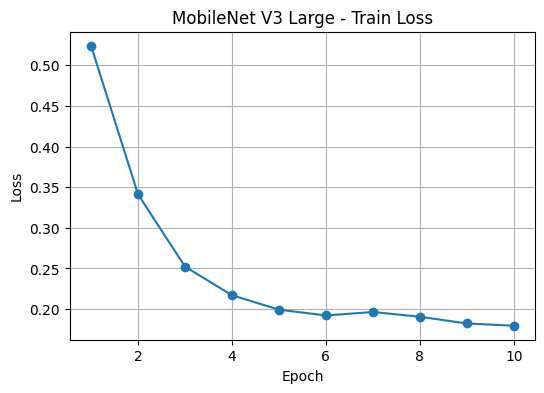

In [252]:
train_loss = [h["train_loss"] for h in mobilenet_history]
plot_series(train_loss, title="MobileNet V3 Large - Train Loss", ylabel="Loss")

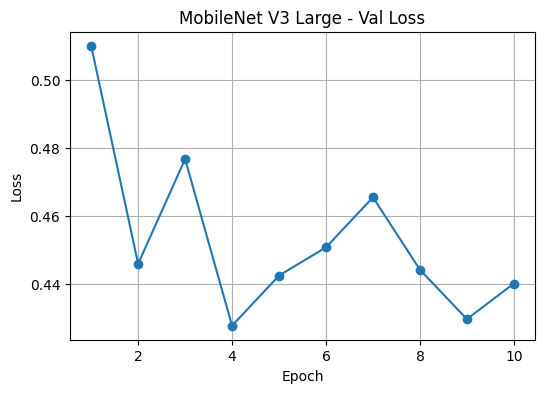

In [253]:
val_loss = [h["loss"] for h in mobilenet_history]
plot_series(val_loss, title="MobileNet V3 Large - Val Loss", ylabel="Loss")

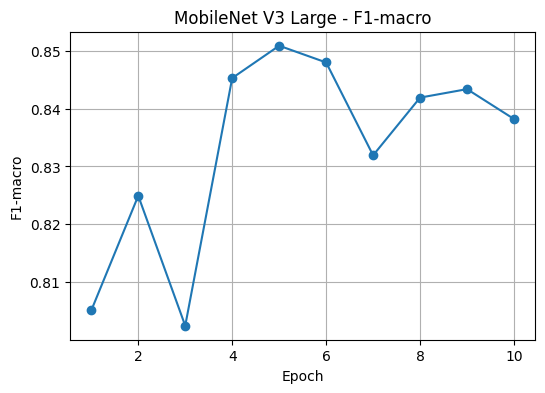

In [254]:
f1_macro = [h["f1_macro"] for h in mobilenet_history]
plot_series(f1_macro, title="MobileNet V3 Large - F1-macro", ylabel="F1-macro")

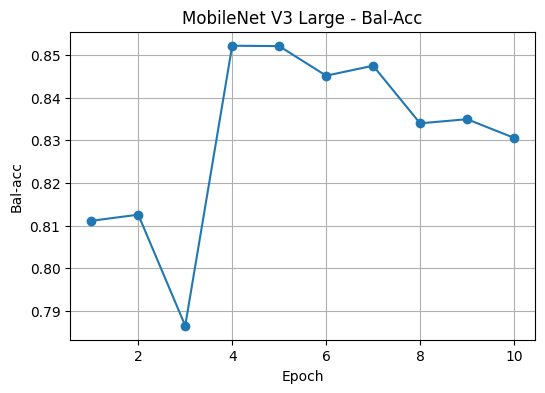

In [255]:
bal_acc = [h["bal_acc"] for h in mobilenet_history]
plot_series(bal_acc, title="MobileNet V3 Large - Bal-Acc", ylabel="Bal-acc")

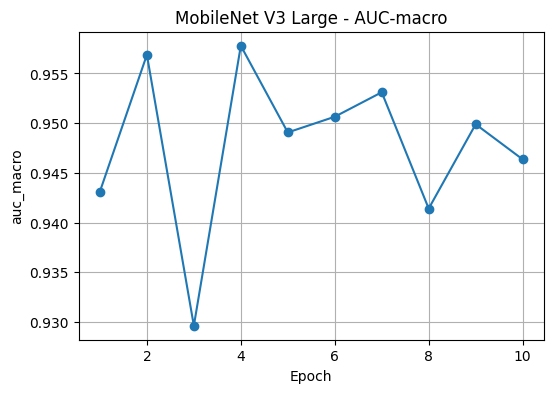

In [256]:
auc_macro = [h["auc_macro"] for h in mobilenet_history]
plot_series(auc_macro, title="MobileNet V3 Large - AUC-macro", ylabel="auc_macro")

#### Métricas en Test y Matriz de Confusión

[mobilenet_v3_large] acc=0.9003 balAcc=0.8548 f1M=0.8528 AUC=0.9538 AP=0.8738 kappa=0.8340 mcc=0.8341

============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       361
           1       0.86      0.88      0.87       274
           2       0.71      0.72      0.71        97

    accuracy                           0.90       732
   macro avg       0.85      0.85      0.85       732
weighted avg       0.90      0.90      0.90       732



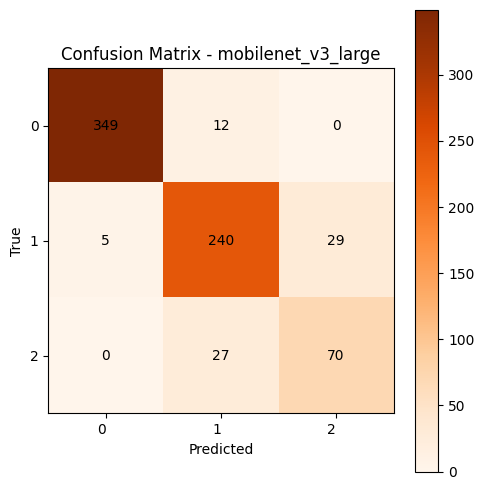

In [172]:
m_mobilenet, mobilenet_metrics_df = run_eval_for_arch("mobilenet_v3_large")

In [244]:
mobilenet_metrics_df

,loss,acc,bal_acc,f1_macro,precision_macro,recall_macro,auc_macro,ap_macro,kappa,mcc
mobilenet_v3_large,0.311179,0.900273,0.854774,0.852834,0.851054,0.854774,0.953788,0.873836,0.83404,0.834144


#### Ejemplos de Inferencia

,preview,image,true_label,top1_label,top2_label,top3_label,top1_prob,top2_prob,top3_prob
0,,d0ffa0425ef1.jpg,2,2,1,0,0.935454,0.040175,0.024372
1,,8a81f62320d6.jpg,0,0,2,1,0.977451,0.014123,0.008426
2,,cb2f3c5d71a7.jpg,1,1,2,0,0.921163,0.056943,0.021895
3,,a19507501b40.jpg,1,1,2,0,0.977110,0.013868,0.009022
4,,2b21d293fdf2.jpg,1,1,0,2,0.983779,0.009310,0.006911
5,,52ae917fcea4.jpg,1,1,0,2,0.988614,0.006265,0.005121

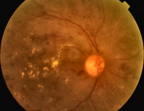
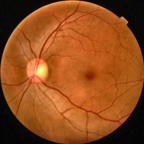
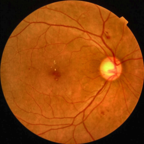
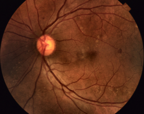
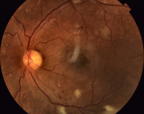
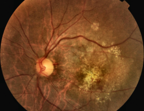

In [194]:
infer_images("run_vB_mobilenet_v3_large_best.pth")

---

### ⚡ EfficientNet B3 - Evaluación Completa

#### Historial de Entrenamiento

In [245]:
efficientnet = load_history("./run_vB_efficientnet_b3_history.pt")

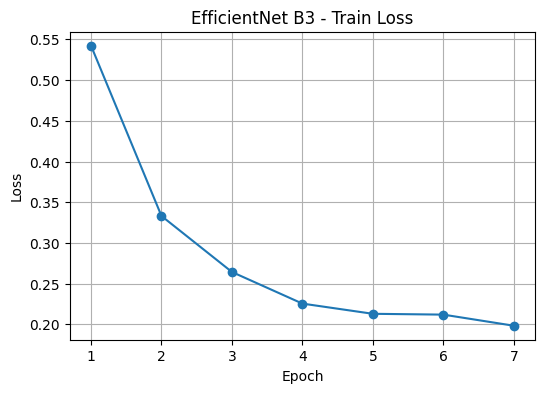

In [246]:
train_loss = [h["train_loss"] for h in efficientnet]
plot_series(train_loss, title="EfficientNet B3 - Train Loss", ylabel="Loss")

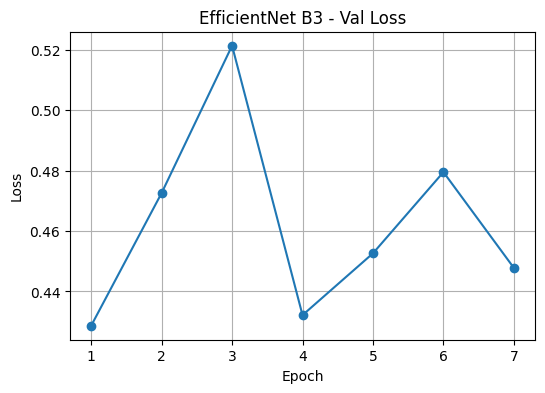

In [247]:
val_loss = [h["loss"] for h in efficientnet]
plot_series(val_loss, title="EfficientNet B3 - Val Loss", ylabel="Loss")

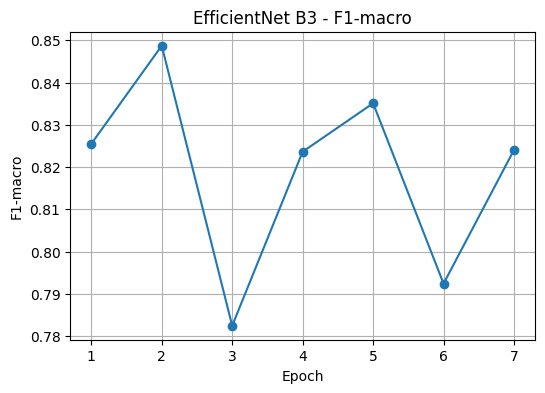

In [248]:
f1_macro = [h["f1_macro"] for h in efficientnet]
plot_series(f1_macro, title="EfficientNet B3 - F1-macro", ylabel="F1-macro")

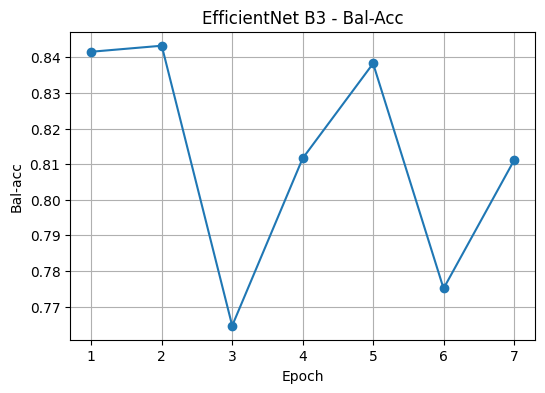

In [249]:
bal_acc = [h["bal_acc"] for h in efficientnet]
plot_series(bal_acc, title="EfficientNet B3 - Bal-Acc", ylabel="Bal-acc")

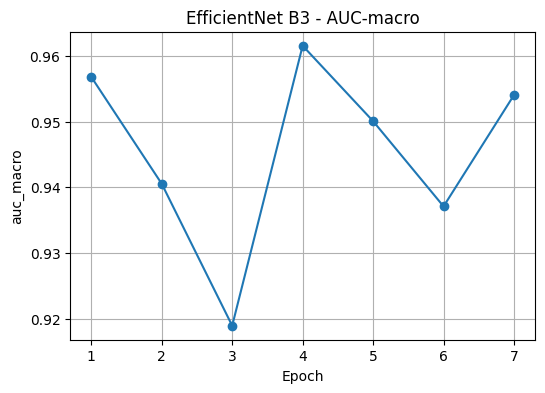

In [250]:
auc_macro = [h["auc_macro"] for h in efficientnet]
plot_series(auc_macro, title="EfficientNet B3 - AUC-macro", ylabel="auc_macro")

#### Métricas en Test y Matriz de Confusión

[efficientnet_b3] acc=0.9030 balAcc=0.8467 f1M=0.8526 AUC=0.9498 AP=0.8885 kappa=0.8377 mcc=0.8386

============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       361
           1       0.84      0.91      0.88       274
           2       0.75      0.67      0.71        97

    accuracy                           0.90       732
   macro avg       0.86      0.85      0.85       732
weighted avg       0.90      0.90      0.90       732



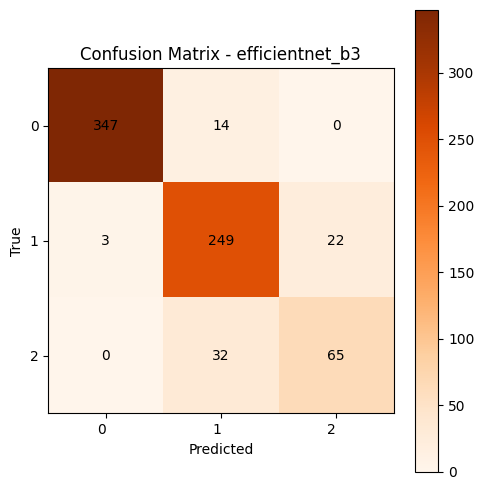

In [179]:
m_efficient, efficientnet_metrics_df = run_eval_for_arch("efficientnet_b3")

In [180]:
efficientnet_metrics_df

,loss,acc,bal_acc,f1_macro,precision_macro,recall_macro,auc_macro,ap_macro,kappa,mcc
efficientnet_b3,0.311234,0.903005,0.846694,0.85261,0.860874,0.846694,0.949779,0.888488,0.837691,0.838564


#### Ejemplos de Inferencia

,preview,image,true_label,top1_label,top2_label,top3_label,top1_prob,top2_prob,top3_prob
0,,d0ffa0425ef1.jpg,2,2,1,0,0.980576,0.016670,0.002754
1,,8a81f62320d6.jpg,0,0,2,1,0.986810,0.006887,0.006302
2,,cb2f3c5d71a7.jpg,1,1,0,2,0.973542,0.015192,0.011266
3,,a19507501b40.jpg,1,1,2,0,0.982260,0.012060,0.005680
4,,2b21d293fdf2.jpg,1,1,2,0,0.636368,0.351036,0.012596
5,,52ae917fcea4.jpg,1,1,2,0,0.626958,0.354353,0.018689

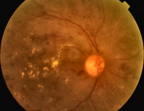
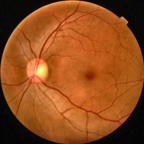
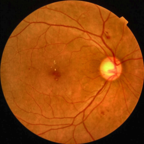
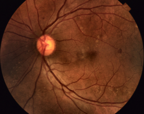
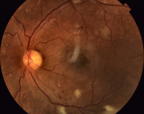
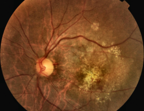

In [192]:
infer_images("run_vB_efficientnet_b3_best.pth")

---

# 📊 COMPARACIÓN FINAL DE RESULTADOS

## Resumen de Métricas por Conjunto de Datos

### Métricas en Validación

Comparación del rendimiento de los tres modelos en el conjunto de validación:

In [242]:
pd.concat([resnet_metrics_df_val, mobilenet_metrics_df_val, efficientnet_metrics_df_val])

,loss,acc,bal_acc,f1_macro,precision_macro,recall_macro,auc_macro,ap_macro,kappa,mcc
resnet50,0.334874,0.878581,0.816006,0.821221,0.827280,0.816006,0.954193,0.864515,0.796417,0.796553
mobilenet_v3_large,0.328133,0.900409,0.852070,0.850873,0.849760,0.852070,0.949066,0.858025,0.834063,0.834094
efficientnet_b3,0.342358,0.901774,0.843242,0.848718,0.855662,0.843242,0.940542,0.848913,0.835660,0.836060


### Métricas en Test

Comparación final del rendimiento de los tres modelos en el conjunto de test:

In [243]:
pd.concat([resnet_metrics_df, mobilenet_metrics_df, efficientnet_metrics_df])

,loss,acc,bal_acc,f1_macro,precision_macro,recall_macro,auc_macro,ap_macro,kappa,mcc
resnet50,0.330220,0.887978,0.834945,0.837718,0.840714,0.834945,0.953169,0.865906,0.812556,0.812591
mobilenet_v3_large,0.311179,0.900273,0.854774,0.852834,0.851054,0.854774,0.953788,0.873836,0.834040,0.834144
efficientnet_b3,0.311234,0.903005,0.846694,0.852610,0.860874,0.846694,0.949779,0.888488,0.837691,0.838564
